# ANTI-SPAM BOT

### All Imports

In [1]:
import base64
import re
import emoji
from email.utils import parsedate_to_datetime
import spacy
from nltk.corpus import stopwords
import nltk
from apiclient.discovery import build
from httplib2 import Http
from oauth2client.file import Storage
from oauth2client.client import flow_from_clientsecrets
from oauth2client.tools import run_flow
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import dateparser

### All Loads

In [2]:
# Load NLTK and SpaCy resources
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

# Google API setup
SCOPES = 'https://www.googleapis.com/auth/gmail.modify'
store = Storage('storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = flow_from_clientsecrets('credentials.json', SCOPES)
    creds = run_flow(flow, store)
GMAIL = build('gmail', 'v1', http=creds.authorize(Http()))

# BERT model setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
label_map = {0: 'General', 1: 'Promotion', 2: 'Work', 3: 'Event'}

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Email extraction and cleaning

In [3]:
def extract_message_body(payload):
    body = ''
    if 'parts' in payload:
        for part in payload['parts']:
            body += extract_message_body(part)
    else:
        body_data = payload.get('body', {}).get('data', '')
        if body_data:
            body = base64.urlsafe_b64decode(body_data).decode('utf-8')
    return body

def clean_message_body(message):
    message = emoji.get_emoji_regexp().sub(r'', message)
    message = re.sub(r'https?://\S+', '', message)
    message = re.sub(r'[\r|\n|\r\n]+', ' ', message).strip()
    # Remove stopwords and lemmatize
    tokens = nlp(message)
    return ' '.join([token.lemma_ for token in tokens if token.text.lower() not in stop_words and not token.is_punct])

### Plotting

In [4]:
def plot_clusters(data_matrix, cluster_labels, title):
    pca = PCA(n_components=2)  # Reduce dimensions to 2 for visualization
    reduced_data = pca.fit_transform(data_matrix.toarray())  # Convert sparse matrix to array before transforming
    plt.figure(figsize=(8, 6))  # Set the figure size
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    plt.show()

### Email classification

In [5]:
def fetch_and_classify_emails():
    response = GMAIL.users().messages().list(userId='me', labelIds=['INBOX'], maxResults=50).execute()
    emails = []
    texts = []
    for msg in response.get('messages', []):
        txt = GMAIL.users().messages().get(userId='me', id=msg['id'], format='full').execute()
        payload = txt.get('payload', {})
        subject = next(header['value'] for header in payload.get('headers', []) if header['name'].lower() == 'subject')
        from_ = next(header['value'] for header in payload.get('headers', []) if header['name'].lower() == 'from')

        body = extract_message_body(payload)
        body = clean_message_body(body)

        inputs = tokenizer(body, return_tensors="tf", truncation=True, padding=True, max_length=512)
        outputs = model(inputs)
        predictions = tf.nn.softmax(outputs.logits, axis=-1)
        predicted_label = label_map[tf.argmax(predictions, axis=1).numpy()[0]]

        emails.append({
            'subject': subject,
            'from': from_,
            'body': body,
            'category': predicted_label
        })
        texts.append(body)

    # Cluster emails using TF-IDF and Count Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    km_tfidf = KMeans(n_clusters=4)  # Adjust number of clusters as necessary
    km_tfidf.fit(tfidf_matrix)

    count_vectorizer = CountVectorizer(max_features=1000)
    count_matrix = count_vectorizer.fit_transform(texts)
    km_count = KMeans(n_clusters=4)  # Adjust number of clusters as necessary
    km_count.fit(count_matrix)

    # Add cluster information to emails
    for idx, email in enumerate(emails):
        email['cluster_tfidf'] = km_tfidf.labels_[idx]
        email['cluster_count'] = km_count.labels_[idx]

    # Visualization of the clusters
    plot_clusters(tfidf_matrix, km_tfidf.labels_, 'TF-IDF Clustering Visualization')
    plot_clusters(count_matrix, km_count.labels_, 'Count Vectorization Clustering Visualization')

    return emails

### Parse + Search

In [6]:

import dateparser

def parse_query(text):
    doc = nlp(text)
    keywords = []
    date_entities = [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    ignored_pos = {'DET', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'AUX', 'ADP', 'SCONJ'}
    for token in doc:
        if token.pos_ not in ignored_pos and token.dep_ not in ['aux', 'auxpass']:
            keywords.append(token.text.lower())
    search_phrase = ' '.join(keywords)
    if 'deadline' in search_phrase or 'due' in search_phrase or 'submission' in search_phrase or 'deadlines' in search_phrase or 'submissions' in search_phrase:
        intent = 'search_deadlines'
    elif date_entities:
        intent = 'search_date'
    else:
        intent = 'search_content'
    return {
        'intent': intent,
        'query': text,
        'search_phrase': search_phrase,
        'date_queries': date_entities,
        'keywords': keywords
    }


def search_emails(query_details, emails):
    results = []
    if query_details['intent'] == 'search_date':
        query_dates = query_details['date_queries']
        for email in emails:
            email_dates = [ent.text for ent in nlp(email['body']).ents if ent.label_ in ['DATE', 'TIME']]
            if any(date in email_dates for date in query_dates):
                results.append(email)
    elif query_details['intent'] == 'search_deadlines':
        keywords = ['deadline', 'due', 'submission']
        for email in emails:
            if any(keyword in email['body'].lower() for keyword in keywords):
                dates = [ent.text for ent in nlp(email['body']).ents if ent.label_ in ['DATE', 'TIME']]
                if dates:
                    results.append({'subject': email['subject'], 'from': email['from'], 'body': email['body'], 'dates': dates})
    else:
        query_text = query_details['search_phrase'].lower()
        for email in emails:
            if query_text in email['body'].lower():
                results.append(email)
    return results


### Response Formatting

In [7]:
def format_response(results):
    if not results:
        return "No relevant emails found."
    response = "Here are the relevant details:\n"
    for email in results:
        date_info = ', '.join(email['dates']) if email['dates'] else "No specific date mentioned"
        response += f"From: {email['from']}, Subject: {email['subject']}, Date/Time: {date_info}\n\n"
    return response

### Summarisation

In [8]:
from transformers import pipeline

# Load a summarization model
summarizer = pipeline("summarization")

def summarize_email_from_sender(emails, sender_name):
    for email in emails:
        if sender_name.lower() in email['from'].lower():
            body = email['body']
            # Truncate the email body to the maximum length the model can handle if necessary
            if len(body) > 1024:
                # Truncate to the max length for BERT, leaving some space for [CLS] and [SEP] tokens
                body = ' '.join(body[:1020].split()[:-1]) + '...'

            if len(body) > 50:  # Ensure the content is not too short for summarization
                summary = summarizer(body, max_length=130, min_length=30, do_sample=False)
                return {
                    'from': email['from'],
                    'subject': email['subject'],
                    'summary': summary[0]['summary_text']
                }
            else:
                return {
                    'from': email['from'],
                    'subject': email['subject'],
                    'summary': body  # Return the original body if too short to summarize
                }
    return "No emails found from the specified sender."

def summarize_last_x_emails(emails, num_emails=5):
    num_emails = min(num_emails, 5)  # Ensure not to exceed the maximum limit
    if len(emails) < num_emails:
        num_emails = len(emails)  # Adjust if fewer emails are available

    summaries = []
    # Iterate over the last 'num_emails' emails
    for email in emails[-num_emails:]:
        body = email['body']
        subject = email['subject']
        if len(body) > 1024:
            body = ' '.join(body[:1020].split()[:-1]) + '...'  # Truncate if necessary

        if len(body) > 50:  # Check if the content is not too short
            summary = summarizer(body, max_length=130, min_length=30, do_sample=False)
            summary_text = summary[0]['summary_text']
        else:
            summary_text = body  # Use the original body if too short to summarize

        # Combine subject and summary
        formatted_summary = f'"{subject}": "{summary_text}"'
        summaries.append(formatted_summary)

    # Combine all formatted summaries separated by two blank lines
    combined_summary = "\n\n".join(summaries)
    return combined_summary


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Chatbot

Hello! Ask me about any events, topics, or summaries of emails from specific senders, or ask to summarize the last X emails.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


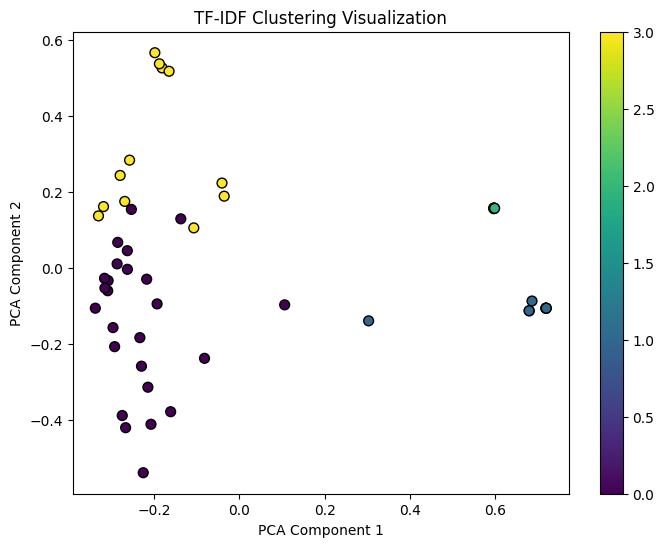

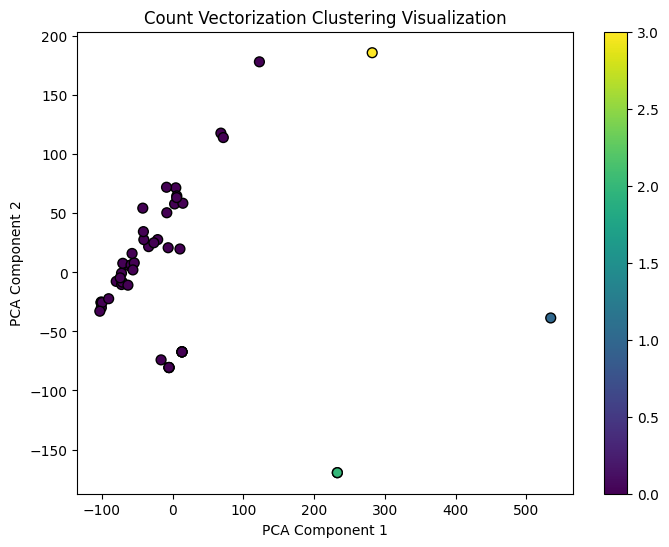

Here are the emails related to your query:
From: Harjot Malik <harjot.malik@ashoka.edu.in>, Subject: Re: Day 2 - English Totally Lit Symposium, Date/Time: 3 pm, May 1 2024, 10:25, today, 5:00   pm, year, year, May 2024, 10:30 5:00, 3 pm, May 1 2024, 10:25, Day two, year, year, May 2024, 5:00 pm

From: The Centre for the Creative and the Critical <ccc@ashoka.edu.in>, Subject: CCC and Westland Books announce the release of 'Against Storytelling', Date/Time: last year, 2018, early year, today, last year, 2018, today

From: Harjot Malik <harjot.malik@ashoka.edu.in>, Subject: Re: Day 2 - English Totally Lit Symposium, Date/Time: today, 5:00   pm, year, year, May 2024, 10:30 5:00 pm, Day two, year, year, May 2024, 5:00 pm

Here are the emails related to your query:
From: "Eeshto: The Gaming Society" <eeshto@ashoka.edu.in>, Subject: Re: Video Games Mixer!!!, Date/Time: May 1 2024 3:15, May 2024, 7 pm, today, 2 Friday, Night Funkin'(Even, Wednesday, style="color, style="color, May 1 2024 3:15,

KeyboardInterrupt: Interrupted by user

In [9]:
def chatbot():
    print("Hello! Ask me about any events, topics, or summaries of emails from specific senders, or ask to summarize the last X emails.")
    emails = fetch_and_classify_emails()
    while True:
        user_input = input("You: ").lower()
        if user_input in ['exit', 'quit']:
            print("Goodbye!")
            break

        if user_input.startswith("summarize last"):
            num_emails = int(re.search(r'\d+', user_input).group())  # Extract number from command
            summary = summarize_last_x_emails(emails, num_emails)
            print("Combined Summary of Last Emails:\n" + summary)
        elif "summarize email from" in user_input:
            sender_name = user_input.split("summarize email from ")[1].strip()
            result = summarize_email_from_sender(emails, sender_name)
            if isinstance(result, str):
                print(result)
            else:
                print(f"From: {result['from']}, Subject: {result['subject']}, Summary: {result['summary']}\n")
        else:
            query_details = parse_query(user_input)
            results = search_emails(query_details, emails)
            if not results:
                print("No relevant emails found concerning: " + user_input)
            else:
                if query_details['intent'] == 'search_deadlines':
                    print("Here are your upcoming deadlines:")
                    for email in results:
                        print(f"From: {email['from']}, Subject: {email['subject']}, Deadlines: {', '.join(email['dates'])}\n")
                else:
                    print("Here are the emails related to your query:")
                    for email in results:
                        date_info = ', '.join([ent.text for ent in nlp(email['body']).ents if ent.label_ in ['DATE', 'TIME']])
                        date_info = date_info if date_info else "No specific date mentioned"
                        print(f"From: {email['from']}, Subject: {email['subject']}, Date/Time: {date_info}\n")

if __name__ == "__main__":
    chatbot()
